<div class='bar_title'></div>

*Data Driven Decisions in Practice (D3IP): Urban Analytics*

# Case Study: Predicting AirBnB Accomodation Prices

Gunther Gust & Nikolai Stein

Data Driven Decisions (D3) Group <br>
Center for Artificial Intelligence & Data Science <br>



<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

Complete the case study outlined by the steps below. Remember to always comment your code and document your findings so that your notebook is easy to read and follow! (Apart from correctness, the style of the notebook will also affect your grade!)



# PART 1: Data Loading and Exploratory Data Analysis

Insructions:

* Load the `airbnb.geojson` file into this notebook as a geodataframe
* Explore the content of each column of the geodataframe using methods of your choice (descriptive statistics, plots etc.). Describe your findings in the markdown cells.
* Create a plot that displays the location of the airbnb listings and the price. Add a basemap of San Diego to the plot.

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt 
import seaborn as sns
import contextily as cx

In [3]:
db = gpd.read_file("airbnb_listings.geojson")

db

,accommodates,bathrooms,bedrooms,beds,rt_Private_room,rt_Shared_room,pg_Condominium,pg_House,pg_Other,pg_Townhouse,price,geometry
0,5,2.0,2.0,2.0,0,0,0,1,0,0,425.0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,0,0,1,0,0,0,205.0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,1,0,0,0,0,0,99.0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,1,0,0,1,0,0,72.0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,1,0,0,1,0,0,55.0,POINT (-117.21870 32.74202)
...,...,...,...,...,...,...,...,...,...,...,...,...
6105,2,1.0,1.0,1.0,1,0,0,0,0,0,79.0,POINT (-117.21635 32.87142)
6106,6,2.0,2.0,2.0,0,0,1,0,0,0,295.0,POINT (-117.16342 32.71036)
6107,1,1.0,1.0,1.0,1,0,0,1,0,0,65.0,POINT (-117.12986 32.74252)
6108,3,1.0,1.0,1.0,0,0,0,0,0,0,170.0,POINT (-117.15070 32.71322)


<Axes: xlabel='accommodates', ylabel='Count'>

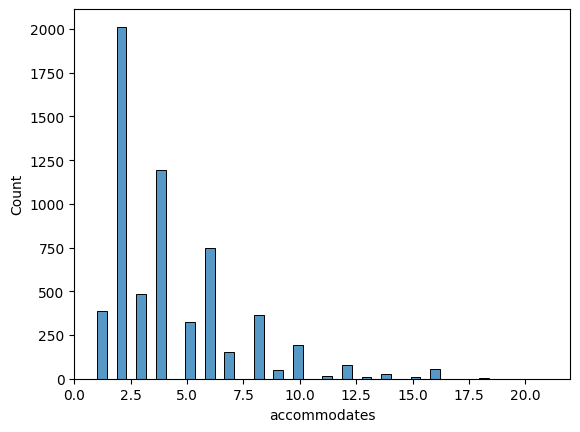

In [4]:
sns.histplot(db["accommodates"])

Most Airbnbs listed, are designed for 2-4 people.

<Axes: xlabel='bathrooms', ylabel='Count'>

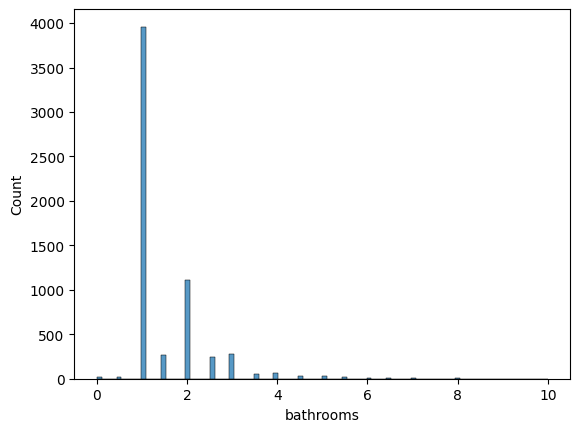

In [5]:
sns.histplot(db["bathrooms"])

Most of the listed Airbnbs have 1-2 bathrooms.

<Axes: xlabel='bedrooms', ylabel='Count'>

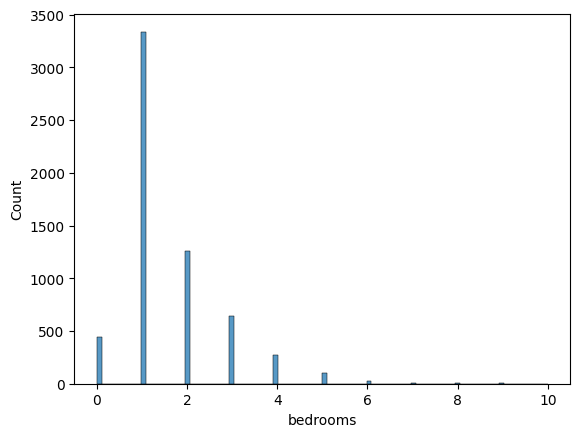

In [6]:
sns.histplot(db["bedrooms"])

Most listed Airbnbs have around 1-2 bedrooms.

<Axes: xlabel='beds', ylabel='Count'>

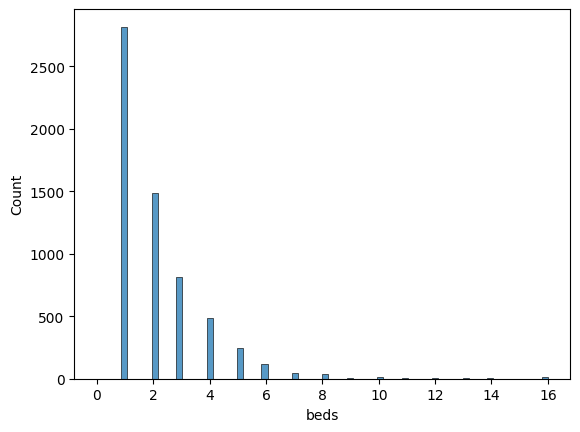

In [7]:
sns.histplot(db["beds"])

Most Airbnbs have around 1-2 beds.
==> In conclusion, most Airbnbs are designed to accommodate single people or small groups of around 2-6 people.

<Axes: xlabel='rt_Private_room', ylabel='Count'>

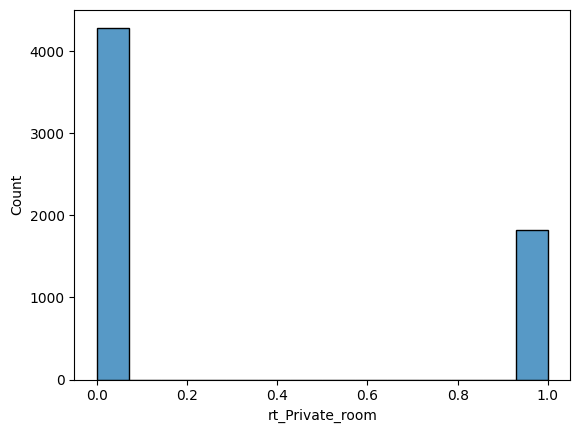

In [8]:
sns.histplot(db["rt_Private_room"])

About one third of the Airbnbs have Private rooms.

<Axes: xlabel='rt_Shared_room', ylabel='Count'>

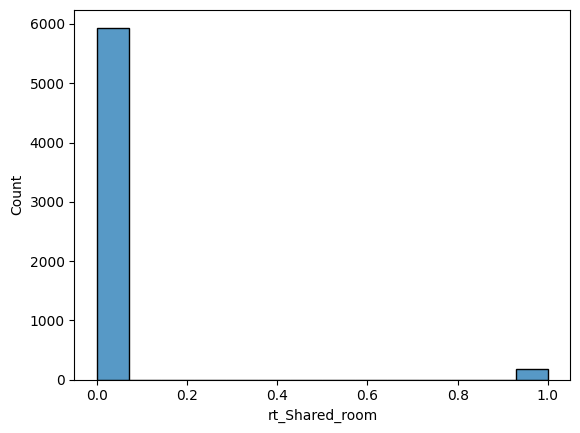

In [9]:
sns.histplot(db["rt_Shared_room"])

Only a small percent of Airbnbs have shared rooms.

<Axes: xlabel='pg_Condominium', ylabel='Count'>

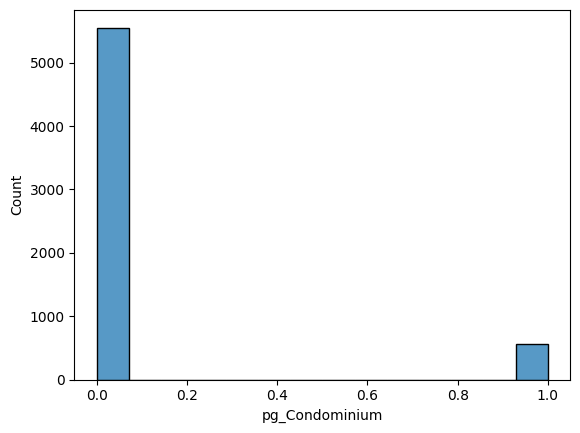

In [10]:
sns.histplot(db["pg_Condominium"])

Only a few of the listed Airbnbs are condos.

<Axes: xlabel='pg_House', ylabel='Count'>

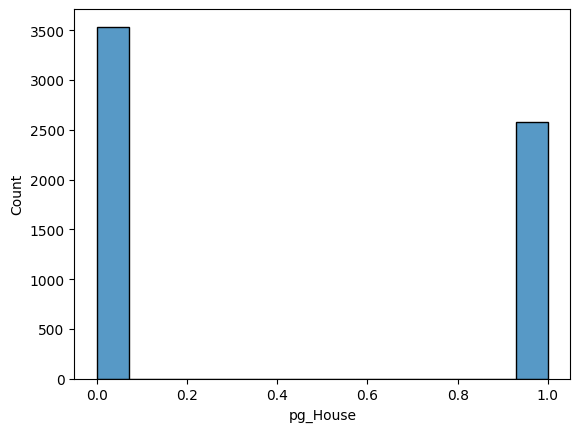

In [11]:
sns.histplot(db["pg_House"])

A little less than half the Airbnbs are houses.

<Axes: xlabel='pg_Townhouse', ylabel='Count'>

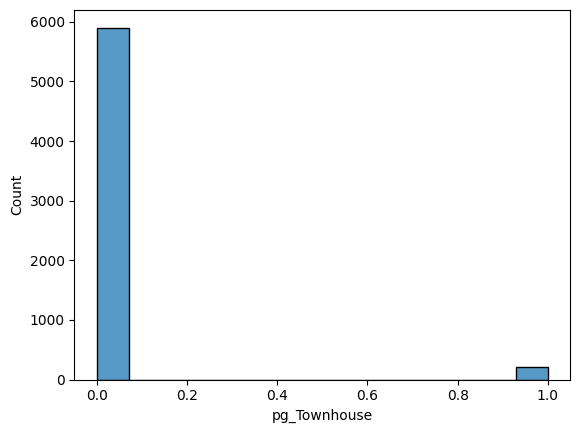

In [12]:
sns.histplot(db["pg_Townhouse"])

Also only a few Airbnbs are townhouses.

<Axes: xlabel='pg_Other', ylabel='Count'>

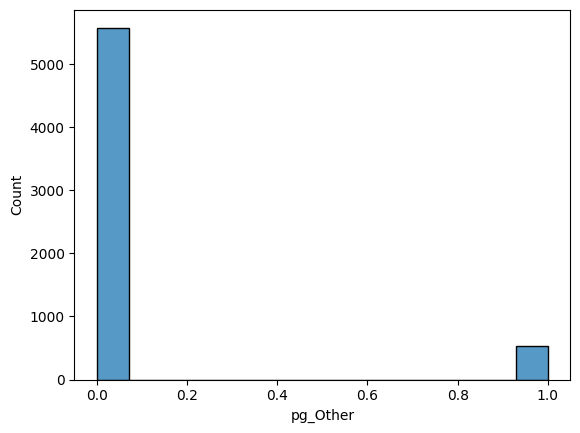

In [13]:
sns.histplot(db["pg_Other"])

The rest of the Airbnbs, which accumulate to around 10% are other kind of properties.

<Axes: xlabel='price', ylabel='Count'>

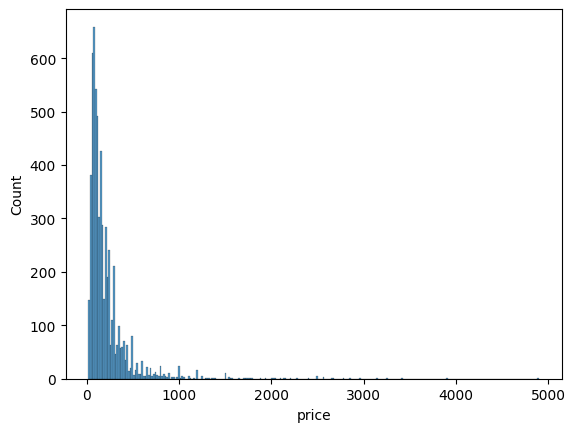

In [14]:
sns.histplot(db["price"])

Most Airbnbs are relativly low priced at below 500$ per night.

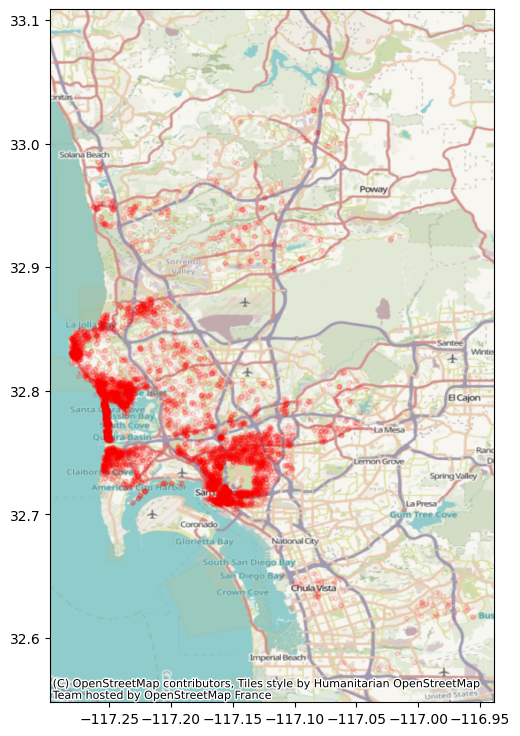

In [15]:
ax = db.plot(alpha=0.1, color="red", figsize=(9, 9), markersize=10)
cx.add_basemap(ax, crs=db.crs)

This map shows the density of the Airbnbs on top of a basemap of San Diego.

Prices arent included in this plot yet.

These are the variables you should analyze and later use to predict the `price`:

In [16]:

variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

# PART 2 Feature Engineering: Get points-of-interest (POIs) and prepare them

Instructions:

* Use the method `features_from_address()` of osmnx to download POIs of the type `amenity` (select the types of amenities to include from this list here: https://wiki.openstreetmap.org/wiki/Key:amenity)
* Pay attention to set the `dist` parameter to an appropiate value 

In [17]:
import osmnx as ox

In [18]:
import osmnx
poi_bars = osmnx.features_from_address(
    "San Diego, USA", dist = 30000, tags={"amenity": "bar"}
)
poi_restaurants = osmnx.features_from_address(
    "San Diego, USA", dist = 30000, tags={"amenity": "restaurant"}
)
poi_taxis = osmnx.features_from_address(
    "San Diego, USA", dist = 30000, tags={"amenity": "taxi"}
)
poi_atms = osmnx.features_from_address(
    "San Diego, USA", dist = 30000, tags={"amenity": "atm"}
)
poi_theatres = osmnx.features_from_address(
    "San Diego, USA", dist = 30000, tags={"amenity": "theatre"}
)


In [19]:
poi_bars.head()

amenity               name  \
element_type osmid                                  
node         365317145     bar  Plum Crazy Saloon   
             365317167     bar        Cozy Corner   
             365317182     bar     Little Bonanza   
             365317212     bar     Mikes Coctails   
             365317227     bar         Tivoli Bar   

                                                                   source  \
element_type osmid                                                          
node         365317145  SanGIS Business Sites Public Domain (http://ww...   
             365317167  SanGIS Business Sites Public Domain (http://ww...   
             365317182  SanGIS Business Sites Public Domain (http://ww...   
             365317212  SanGIS Business Sites Public Domain (http://ww...   
             365317227  SanGIS Business Sites Public Domain (http://ww...   

                                           geometry addr:city addr:country  \
element_type osmid                                                           
node         365317145  POINT (-117.07185 32.66029)       NaN          NaN   
             365317167  POINT (-117.07234 32.66811)       NaN          NaN   
             365317182  POINT (-117.11332 32.58428)       NaN          NaN   
             365317212  POINT (-117.00955 32.70848)       NaN          NaN   
             365317227  POINT (-117.15892 32.71057)       NaN          NaN   

                       addr:housenumber addr:postcode addr:street addr:state  \
element_type osmid                                                             
node         365317145              NaN           NaN         NaN        NaN   
             365317167              NaN           NaN         NaN        NaN   
             365317182              NaN           NaN         NaN        NaN   
             365317212              NaN           NaN         NaN        NaN   
             365317227              NaN           NaN         NaN        NaN   

                        ... opening_hours:covid19 payment:apple_pay  \
element_type osmid      ...                                           
node         365317145  ...                   NaN               NaN   
             365317167  ...                   NaN               NaN   
             365317182  ...                   NaN               NaN   
             365317212  ...                   NaN               NaN   
             365317227  ...                   NaN               NaN   

                       payment:contactless liquor roof:levels takeaway  \
element_type osmid                                                       
node         365317145                 NaN    NaN         NaN      NaN   
             365317167                 NaN    NaN         NaN      NaN   
             365317182                 NaN    NaN         NaN      NaN   
             365317212                 NaN    NaN         NaN      NaN   
             365317227                 NaN    NaN         NaN      NaN   

                       created_by leisure level indoor  
element_type osmid                                      
node         365317145        NaN     NaN   NaN    NaN  
             365317167        NaN     NaN   NaN    NaN  
             365317182        NaN     NaN   NaN    NaN  
             365317212        NaN     NaN   NaN    NaN  
             365317227        NaN     NaN   NaN    NaN  

[5 rows x 73 columns]

Data cleaning: The resulting `pois` geodataframe may have a composite row index. In addition, some POIs may be of a strange element_type. You can use the following code to eliminate these issues.

In [20]:

poi_bars.reset_index(inplace=True) 
poi_bars = poi_bars[poi_bars.element_type=="node"]
poi_restaurants.reset_index(inplace=True) 
poi_restaurants = poi_restaurants[poi_restaurants.element_type=="node"] 
poi_atms.reset_index(inplace=True) 
poi_atms = poi_atms[poi_atms.element_type=="node"] 
poi_taxis.reset_index(inplace=True) 
poi_taxis = poi_taxis[poi_taxis.element_type=="node"] 
poi_theatres.reset_index(inplace=True) 
poi_theatres = poi_theatres[poi_theatres.element_type=="node"]  


Instructions:
* Plot the POIs spatially (use again a background map of San Diego)
* When you use POIs of different amenity types, color the POIs differently

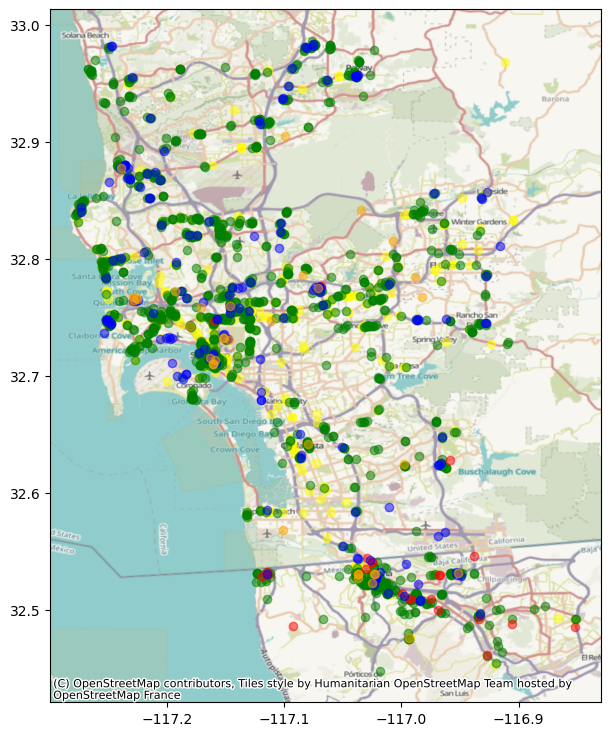

In [21]:
f, ax = plt.subplots(1, figsize=(9, 9))
poi_bars.plot(ax=ax, color="yellow", alpha = 0.5)
poi_restaurants.plot(ax=ax, color="green", alpha = 0.5)
poi_taxis.plot(ax=ax, color = "red", alpha = 0.5)
poi_atms.plot(ax=ax, color = "blue", alpha = 0.5)
poi_theatres.plot(ax=ax, color ="orange", alpha = 0.5)

cx.add_basemap(ax, crs=poi_bars.crs)

plt.show()


For each POI amenity type, create a kernel density estimation (KDE):
* Convert the `geometry` of the POI into a suitable coordinate data format (you may use the provided function `create_coordinate_array` for this)
* Feed the resulting coordinates into the `gaussian_kde` function and estimate the function
* Also convert the `geometry` of the Airbnb listings into the coordinate data format (you may use the provided function `create_coordinate_array` for this)
* Using the converted Airbnb geometries, compute the KDE for the locations of the Airbnb listings
* Add the KDE estimate as additional columns to your original airbnb geodataframe

In [22]:
from scipy.stats import gaussian_kde

In [23]:

def create_coordinate_array(geometries): 
    coordinates = []
    
    
    for multipoint in geometries:
        points = list(multipoint.geoms) if hasattr(multipoint, "geoms") else [multipoint]
        
        for point in points:
            coordinates.append((point.x, point.y))

    return coordinates


bars_array = create_coordinate_array(poi_bars.geometry)
restaurants_array = create_coordinate_array(poi_restaurants.geometry)
taxis_array = create_coordinate_array(poi_taxis.geometry)
atms_array = create_coordinate_array(poi_atms.geometry)
theatres_array = create_coordinate_array(poi_theatres.geometry)
Airbnb_array = create_coordinate_array(db.geometry)



In [24]:

bars_kde = gaussian_kde(np.transpose(bars_array))

bars_xmin, bars_ymin = np.min(bars_array, axis=0)
bars_xmax, bars_ymax = np.max(bars_array, axis=0)
xx, yy = np.mgrid[bars_xmin:bars_xmax:100j, bars_ymin:bars_ymax:100j]

bars_positions = np.vstack([xx.ravel(), yy.ravel()])
bars_density = bars_kde(bars_positions).reshape(xx.shape)


Create a spatial point plot(s) of the Airbnb listings and color the points according to the KDE estimates, in order to check your results.

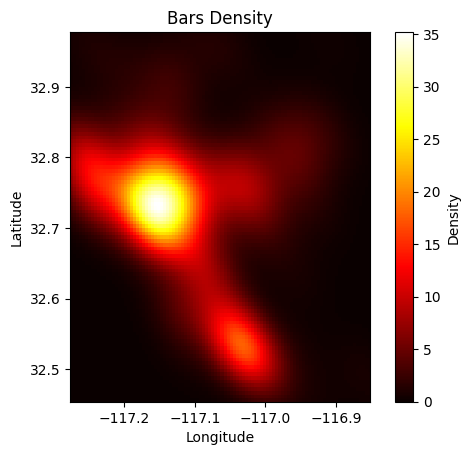

In [39]:
plt.imshow(np.rot90(bars_density), cmap='hot', extent=[bars_xmin, bars_xmax, bars_ymin, bars_ymax])
plt.colorbar(label='Density')
plt.title('Bars Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [27]:
restaurants_kde = gaussian_kde(np.transpose(restaurants_array))  

restaurants_xmin, restaurants_ymin = np.min(restaurants_array, axis=0)
restaurants_xmax, restaurants_ymax = np.max(restaurants_array, axis=0)
xx, yy = np.mgrid[restaurants_xmin:restaurants_xmax:100j, restaurants_ymin:restaurants_ymax:100j]

restaurants_positions = np.vstack([xx.ravel(), yy.ravel()])
restaurants_density = restaurants_kde(restaurants_positions).reshape(xx.shape)


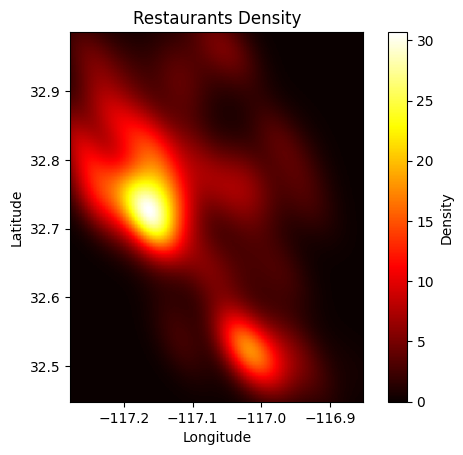

In [37]:
plt.imshow(np.rot90(restaurants_density), cmap='hot', extent=[restaurants_xmin, restaurants_xmax, restaurants_ymin, restaurants_ymax])
plt.colorbar(label='Density')
plt.title('Restaurants Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [30]:
taxis_kde = gaussian_kde(np.transpose(taxis_array)) 

taxis_xmin, taxis_ymin = np.min(taxis_array, axis=0)
taxis_xmax, taxis_ymax = np.max(taxis_array, axis=0)
xx, yy = np.mgrid[taxis_xmin:taxis_xmax:100j, taxis_ymin:taxis_ymax:100j]

taxis_positions = np.vstack([xx.ravel(), yy.ravel()])
taxis_density = taxis_kde(taxis_positions).reshape(xx.shape)

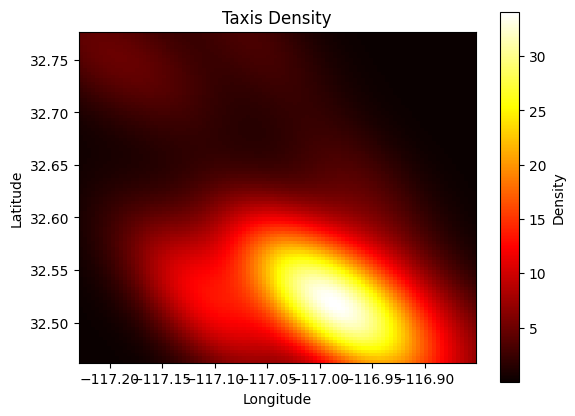

In [40]:
plt.imshow(np.rot90(taxis_density), cmap='hot', extent=[taxis_xmin, taxis_xmax, taxis_ymin, taxis_ymax])
plt.colorbar(label='Density')
plt.title('Taxis Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [32]:
atms_kde = gaussian_kde(np.transpose(atms_array))  

atms_xmin, atms_ymin = np.min(atms_array, axis=0)
atms_xmax, atms_ymax = np.max(atms_array, axis=0)
xx, yy = np.mgrid[atms_xmin:atms_xmax:100j, atms_ymin:atms_ymax:100j]

atms_positions = np.vstack([xx.ravel(), yy.ravel()])
atms_density = atms_kde(atms_positions).reshape(xx.shape)


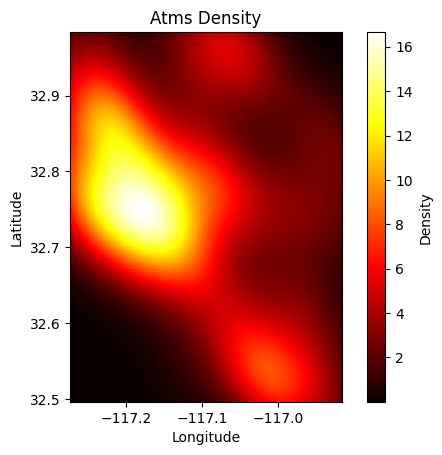

In [41]:
plt.imshow(np.rot90(atms_density), cmap='hot', extent=[atms_xmin, atms_xmax, atms_ymin, atms_ymax])
plt.colorbar(label='Density')
plt.title('Atms Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [34]:
theatres_kde = gaussian_kde(np.transpose(theatres_array))  

theatres_xmin, theatres_ymin = np.min(theatres_array, axis=0)
theatres_xmax, theatres_ymax = np.max(theatres_array, axis=0)
xx, yy = np.mgrid[theatres_xmin:theatres_xmax:100j, theatres_ymin:theatres_ymax:100j]

theatres_positions = np.vstack([xx.ravel(), yy.ravel()])
theatres_density = theatres_kde(theatres_positions).reshape(xx.shape)

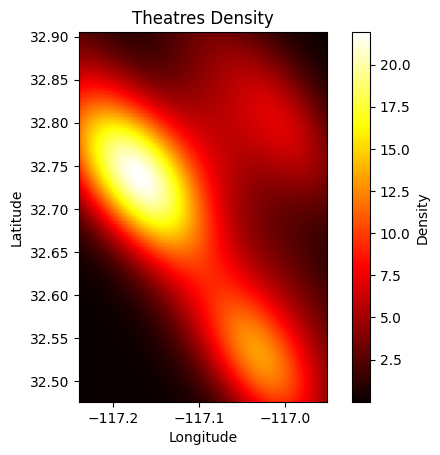

In [42]:
plt.imshow(np.rot90(theatres_density), cmap='hot', extent=[theatres_xmin, theatres_xmax, theatres_ymin, theatres_ymax])
plt.colorbar(label='Density')
plt.title('Theatres Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [44]:
Airbnb_kde = gaussian_kde(np.transpose(Airbnb_array))  

Airbnb_xmin, Airbnb_ymin = np.min(Airbnb_array, axis=0)
Airbnb_xmax, Airbnb_ymax = np.max(Airbnb_array, axis=0)
xx, yy = np.mgrid[Airbnb_xmin:Airbnb_xmax:100j, Airbnb_ymin:Airbnb_ymax:100j]

Airbnb_positions = np.vstack([xx.ravel(), yy.ravel()])
Airbnb_density = Airbnb_kde(Airbnb_positions).reshape(xx.shape)

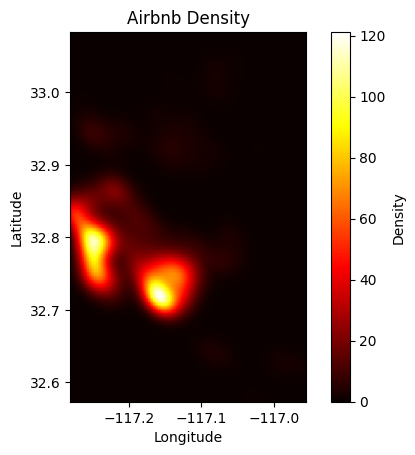

In [46]:
plt.imshow(np.rot90(Airbnb_density), cmap='hot', extent=[Airbnb_xmin, Airbnb_xmax, Airbnb_ymin, Airbnb_ymax])
plt.colorbar(label='Density')
plt.title('Airbnb Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [47]:
xy = np.vstack([db.geometry.x, db.geometry.y])
Airbnb_kde = gaussian_kde(xy)
density = Airbnb_kde(xy)
db['kde_density'] = density
print(db.head())


   accommodates  bathrooms  bedrooms  beds  rt_Private_room  rt_Shared_room  \
0             5        2.0       2.0   2.0                0               0   
1             6        1.0       2.0   4.0                0               0   
2             2        1.0       1.0   1.0                1               0   
3             2        1.0       1.0   1.0                1               0   
4             2        1.0       1.0   1.0                1               0   

   pg_Condominium  pg_House  pg_Other  pg_Townhouse  price  \
0               0         1         0             0  425.0   
1               1         0         0             0  205.0   
2               0         0         0             0   99.0   
3               0         1         0             0   72.0   
4               0         1         0             0   55.0   

                      geometry  kde_density  
0  POINT (-117.12971 32.75399)    58.758892  
1  POINT (-117.25253 32.78421)   106.179272  
2  POINT (-117

# PART 3: Modeling and Analysis (aka Machine Learning)

Use your dataset generated in the previous steps to predict AirBnb prices

Instructions:

* Split your data set into training and validation data sets
* Define an error metric (or several)
* Train at least one machine learning model (e.g. random forest) 
* Tune the hyperparameters (if applicable for the model)
* Evaluate the accuracy of the predicted prices against actual prices
* Compare the performance of the previous models when using different input data sets (benchmarks). Make sure to include the naive benchmark of predicting always the mean price.

In [53]:
from sklearn.model_selection import train_test_split

print(db.shape)
db.dropna(axis=0, inplace=True)
print(db.shape)

y = db["price"]
db_features = ["accommodates", "bathrooms", "bedrooms", "beds", "rt_Private_room", "rt_Shared_room", "pg_Condominium", "pg_House", "pg_Other", "pg_Townhouse"]
x = db[db_features]

(6110, 13)
(6110, 13)


==> no missing values

In [54]:
print(x.shape)
x.head()

(6110, 10)


,accommodates,bathrooms,bedrooms,beds,rt_Private_room,rt_Shared_room,pg_Condominium,pg_House,pg_Other,pg_Townhouse
0,5,2.0,2.0,2.0,0,0,0,1,0,0
1,6,1.0,2.0,4.0,0,0,1,0,0,0
2,2,1.0,1.0,1.0,1,0,0,0,0,0
3,2,1.0,1.0,1.0,1,0,0,1,0,0
4,2,1.0,1.0,1.0,1,0,0,1,0,0


In [55]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,6110.0,4.220786,2.840703,1.0,2.0,4.0,6.0,21.0
bathrooms,6110.0,1.475286,0.863803,0.0,1.0,1.0,2.0,10.0
bedrooms,6110.0,1.589198,1.136234,0.0,1.0,1.0,2.0,10.0
beds,6110.0,2.196399,1.712917,0.0,1.0,2.0,3.0,16.0
rt_Private_room,6110.0,0.298363,0.457577,0.0,0.0,0.0,1.0,1.0
rt_Shared_room,6110.0,0.027987,0.164949,0.0,0.0,0.0,0.0,1.0
pg_Condominium,6110.0,0.090998,0.287630,0.0,0.0,0.0,0.0,1.0
pg_House,6110.0,0.421440,0.493830,0.0,0.0,0.0,1.0,1.0
pg_Other,6110.0,0.087234,0.282201,0.0,0.0,0.0,0.0,1.0
pg_Townhouse,6110.0,0.033879,0.180932,0.0,0.0,0.0,0.0,1.0


Splitting dataset:

In [65]:
from sklearn.model_selection import train_test_split

# Split the data
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state = 0)


## Model 1: Decision Tree

Defining and fitting the model:

In [80]:
# Trivial baseline: Predict always the mean price 

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

db_tree_model = DecisionTreeRegressor(random_state=1)

db_tree_model.fit(x, y)

DecisionTreeRegressor(random_state=1)

First predicitions:

In [81]:
predicted_prices = db_tree_model.predict(x)
mae = mean_absolute_error(y, predicted_prices)

print(mae)

54.558428359698254


In [82]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state = 0)

db__tree_model = DecisionTreeRegressor(random_state=1)
db_tree_model.fit(train_x, train_y)


val_predictions = db_tree_model.predict(val_x)
val_mae = mean_absolute_error(val_y, val_predictions)

print(val_mae)

101.70885436846896


==> High mae , the model has to be tuned.

In [83]:
def get_mae(max_leaf_nodes, train_x, val_x, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_x, train_y)
    preds_val = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [84]:
for max_leaf_nodes in [2, 5, 50, 500, 1000, 5000]:
    is_mae = get_mae(max_leaf_nodes, x, x, y, y)
    oos_mae = get_mae(max_leaf_nodes, train_x, val_x, train_y, val_y)
    print("Max leaf nodes: %d  \t In-sample:  %d \t Out-of-sample:  %d" %(max_leaf_nodes, is_mae, oos_mae))

Max leaf nodes: 2  	 In-sample:  132 	 Out-of-sample:  134
Max leaf nodes: 5  	 In-sample:  105 	 Out-of-sample:  107
Max leaf nodes: 50  	 In-sample:  75 	 Out-of-sample:  97
Max leaf nodes: 500  	 In-sample:  58 	 Out-of-sample:  99
Max leaf nodes: 1000  	 In-sample:  54 	 Out-of-sample:  101
Max leaf nodes: 5000  	 In-sample:  54 	 Out-of-sample:  101


In [85]:
for max_leaf_nodes in [30, 40, 50, 60, 70]:
    is_mae = get_mae(max_leaf_nodes, x, x, y, y)
    oos_mae = get_mae(max_leaf_nodes, train_x, val_x, train_y, val_y)
    print("Max leaf nodes: %d  \t In-sample:  %d \t Out-of-sample:  %d" %(max_leaf_nodes, is_mae, oos_mae))

Max leaf nodes: 30  	 In-sample:  79 	 Out-of-sample:  96
Max leaf nodes: 40  	 In-sample:  78 	 Out-of-sample:  98
Max leaf nodes: 50  	 In-sample:  75 	 Out-of-sample:  97
Max leaf nodes: 60  	 In-sample:  74 	 Out-of-sample:  98
Max leaf nodes: 70  	 In-sample:  73 	 Out-of-sample:  98


In [86]:
for max_leaf_nodes in [20, 25, 30, 35, 40]:
    is_mae = get_mae(max_leaf_nodes, x, x, y, y)
    oos_mae = get_mae(max_leaf_nodes, train_x, val_x, train_y, val_y)
    print("Max leaf nodes: %d  \t In-sample:  %d \t Out-of-sample:  %d" %(max_leaf_nodes, is_mae, oos_mae))

Max leaf nodes: 20  	 In-sample:  84 	 Out-of-sample:  100
Max leaf nodes: 25  	 In-sample:  82 	 Out-of-sample:  97
Max leaf nodes: 30  	 In-sample:  79 	 Out-of-sample:  96
Max leaf nodes: 35  	 In-sample:  78 	 Out-of-sample:  98
Max leaf nodes: 40  	 In-sample:  78 	 Out-of-sample:  98


==> The best amount of leaf nodes in this model is 30, so you dont over- or underfit.

## Model 2: Random Forest

In [90]:
from sklearn.ensemble import RandomForestRegressor

db_forest_model = RandomForestRegressor(random_state=1, n_estimators=100)

db_forest_model.fit(train_x, train_y)

forest_predictions = db_forest_model.predict(val_x)
mae_forest = mean_absolute_error(val_y, forest_predictions)
print(mae_forest)

92.70063132110634


Compared to our first Model the mae is a little bit lower, which makes Model 2 more accurate.

As we dont have any missing values in our dataset, we cant do Missing Value Imputation.